In [1]:
import pandas as pd 
import numpy as np 
import os 
import datetime
from pandas import *
from pandas.plotting import lag_plot, autocorrelation_plot
import matplotlib.pyplot as plt 
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from math import sqrt
import mysql.connector
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import pacf
from statsmodels.regression.linear_model import yule_walker
from statsmodels.tsa.stattools import adfuller
from mysql.connector import connection
import seaborn as sns 


In [2]:
connection = mysql.connector.connect(
        host=  os.environ.get('host'), 
        port=  3310,
        database = 'database_fiumi',  #'rivers_db'
        user =  os.environ.get('user'),
        password = os.environ.get('password')
        )
connection.autocommit = True
cursor = connection.cursor()

In [3]:
query = 'SELECT Timestamp, WT_mean from Tabella_Talvera' 
df = pd.read_sql(query, con=connection)
# print(df)

In [4]:
# CLEAN THE DATA
droppare = []
i = 0 
while i < (len(df['WT_mean'])):
        if np.isnan(df['WT_mean'].iloc[i]):
                droppare.append(i)
        i += 1

for j in droppare :
    df =  df.drop(j)

df

,Timestamp,WT_mean
0,2019-03-10 19:00:00,7.60
1,2019-03-10 20:00:00,7.53
2,2019-03-10 21:00:00,7.38
3,2019-03-10 22:00:00,7.37
4,2019-03-10 23:00:00,7.45
...,...,...
19986,2021-06-20 19:00:00,13.90
19987,2021-06-20 20:00:00,13.90
19988,2021-06-20 21:00:00,13.82
19989,2021-06-20 22:00:00,13.73


In [6]:
print(df['Timestamp'])

0       2019-03-10 19:00:00
1       2019-03-10 20:00:00
2       2019-03-10 21:00:00
3       2019-03-10 22:00:00
4       2019-03-10 23:00:00
                ...        
19986   2021-06-20 19:00:00
19987   2021-06-20 20:00:00
19988   2021-06-20 21:00:00
19989   2021-06-20 22:00:00
19990   2021-06-20 23:00:00
Name: Timestamp, Length: 19991, dtype: datetime64[ns]


In [7]:
df.describe()

,index,WT_mean
count,19991.000000,19991.000000
mean,9995.000000,8.479188
std,5771.048951,3.881205
min,0.000000,0.100000
25%,4997.500000,5.000000
50%,9995.000000,8.170000
75%,14992.500000,11.720000
max,19990.000000,23.400000


In [8]:
df.columns

Index(['index', 'Timestamp', 'WT_mean'], dtype='object')

In [9]:
df.iloc[7106]

index                       7106
Timestamp    2019-12-31 23:00:00
WT_mean                        4
Name: 7106, dtype: object

In [10]:
#Create a df for the year 2019
y_19 = df.iloc[:7107]
y_19

,index,Timestamp,WT_mean
0,0,2019-03-10 19:00:00,7.60
1,1,2019-03-10 20:00:00,7.53
2,2,2019-03-10 21:00:00,7.38
3,3,2019-03-10 22:00:00,7.37
4,4,2019-03-10 23:00:00,7.45
...,...,...,...
7102,7102,2019-12-31 19:00:00,3.88
7103,7103,2019-12-31 20:00:00,3.92
7104,7104,2019-12-31 21:00:00,4.00
7105,7105,2019-12-31 22:00:00,4.02


In [11]:
#Create a df for the year 2020
y_20 = df.iloc[7107:15888]
y_20

,index,Timestamp,WT_mean
7107,7107,2020-01-01 00:00:00,3.93
7108,7108,2020-01-01 01:00:00,3.97
7109,7109,2020-01-01 02:00:00,4.00
7110,7110,2020-01-01 03:00:00,4.00
7111,7111,2020-01-01 04:00:00,4.00
...,...,...,...
15883,15883,2020-12-31 19:00:00,2.42
15884,15884,2020-12-31 20:00:00,2.43
15885,15885,2020-12-31 21:00:00,2.50
15886,15886,2020-12-31 22:00:00,2.40


In [12]:
#Create a df for the year 2021
y_21 = df.iloc[15922:]
y_21

,index,Timestamp,WT_mean
15922,15922,2021-01-02 10:00:00,2.80
15923,15923,2021-01-02 11:00:00,2.85
15924,15924,2021-01-02 12:00:00,2.98
15925,15925,2021-01-02 13:00:00,3.10
15926,15926,2021-01-02 14:00:00,3.20
...,...,...,...
19986,19986,2021-06-20 19:00:00,13.90
19987,19987,2021-06-20 20:00:00,13.90
19988,19988,2021-06-20 21:00:00,13.82
19989,19989,2021-06-20 22:00:00,13.73


In [18]:
#tks = np.arange(min(df['Timestamp']), max(df['Timestamp']), 30)
min_time = (min(df['Timestamp']))   
max_time = (max(df['Timestamp']))
ticks = []
#tks = np.arange(min_time, max_time)
start_time = df['Timestamp'].iloc[0]
start_time = str(start_time)
start_time = start_time.split()
start_time = start_time[0]
print(start_time)
x_data = pd.date_range(start_time, periods=30, freq='MS') 
# Check how this dates looks like:
print(x_data)
for i in range(len(df)):
    ticks.append(i)
    
len(ticks)

2019-03-10
DatetimeIndex(['2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01',
               '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01',
               '2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01',
               '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
               '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01',
               '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01',
               '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01',
               '2021-08-01', '2021-09-01'],
              dtype='datetime64[ns]', freq='MS')


19991

In [14]:
df['Timestamp']

0       2019-03-10 19:00:00
1       2019-03-10 20:00:00
2       2019-03-10 21:00:00
3       2019-03-10 22:00:00
4       2019-03-10 23:00:00
                ...        
19986   2021-06-20 19:00:00
19987   2021-06-20 20:00:00
19988   2021-06-20 21:00:00
19989   2021-06-20 22:00:00
19990   2021-06-20 23:00:00
Name: Timestamp, Length: 19991, dtype: datetime64[ns]

In [15]:
y_21.set_index('Timestamp')
y_20.set_index('Timestamp')
y_19.set_index('Timestamp')

y_20

,index,Timestamp,WT_mean
7107,7107,2020-01-01 00:00:00,3.93
7108,7108,2020-01-01 01:00:00,3.97
7109,7109,2020-01-01 02:00:00,4.00
7110,7110,2020-01-01 03:00:00,4.00
7111,7111,2020-01-01 04:00:00,4.00
...,...,...,...
15883,15883,2020-12-31 19:00:00,2.42
15884,15884,2020-12-31 20:00:00,2.43
15885,15885,2020-12-31 21:00:00,2.50
15886,15886,2020-12-31 22:00:00,2.40


In [19]:

plt.figure(figsize=(16,10), dpi=100)

plt.plot(y_21['WT_mean'], label = '2021')
plt.plot(y_20['WT_mean'], color = 'green', label= '2020')
plt.plot(y_19['WT_mean'], color = 'red', label = '2019' )
plt.xlabel('Date')
plt.ylabel('Water Level')
plt.title('Water level Isarco')
plt.legend()
plt.xticks(ticks, rotation = 'vertical')
# MODIFICARE I TICKS 
plt.show()


KeyboardInterrupt: 

In [185]:
# Output the maximum and minimum temperature date
print(df.loc[df["WT_mean"] == df["WT_mean"].max()])
print(df.loc[df["WT_mean"] == df["WT_mean"].min()])

      index           Timestamp  WT_mean
3669   3669 2019-08-10 17:00:00     23.4
       index           Timestamp  WT_mean
16133  16133 2021-01-11 05:00:00      0.1
16156  16156 2021-01-12 04:00:00      0.1
16157  16157 2021-01-12 05:00:00      0.1


In [194]:
list_date = ['2019-08-10', '2021-01-11', '2022-01-11']
max(list_date)
min(list_date)
xticks = np.arange(0, len(df),10)
xticks

array([    0,    10,    20, ..., 19970, 19980, 19990])

In [220]:


n_obs = []
dates_ticks = list()
for el in df['Timestamp']:
    el = str(el)
    el = el.split()
    el = el[0]
    if el.endswith('01') and el not in dates_ticks:
        dates_ticks.append(el)
    else:
        dates_ticks.append('')
    n_obs.append(i)
len(n_obs)

19991

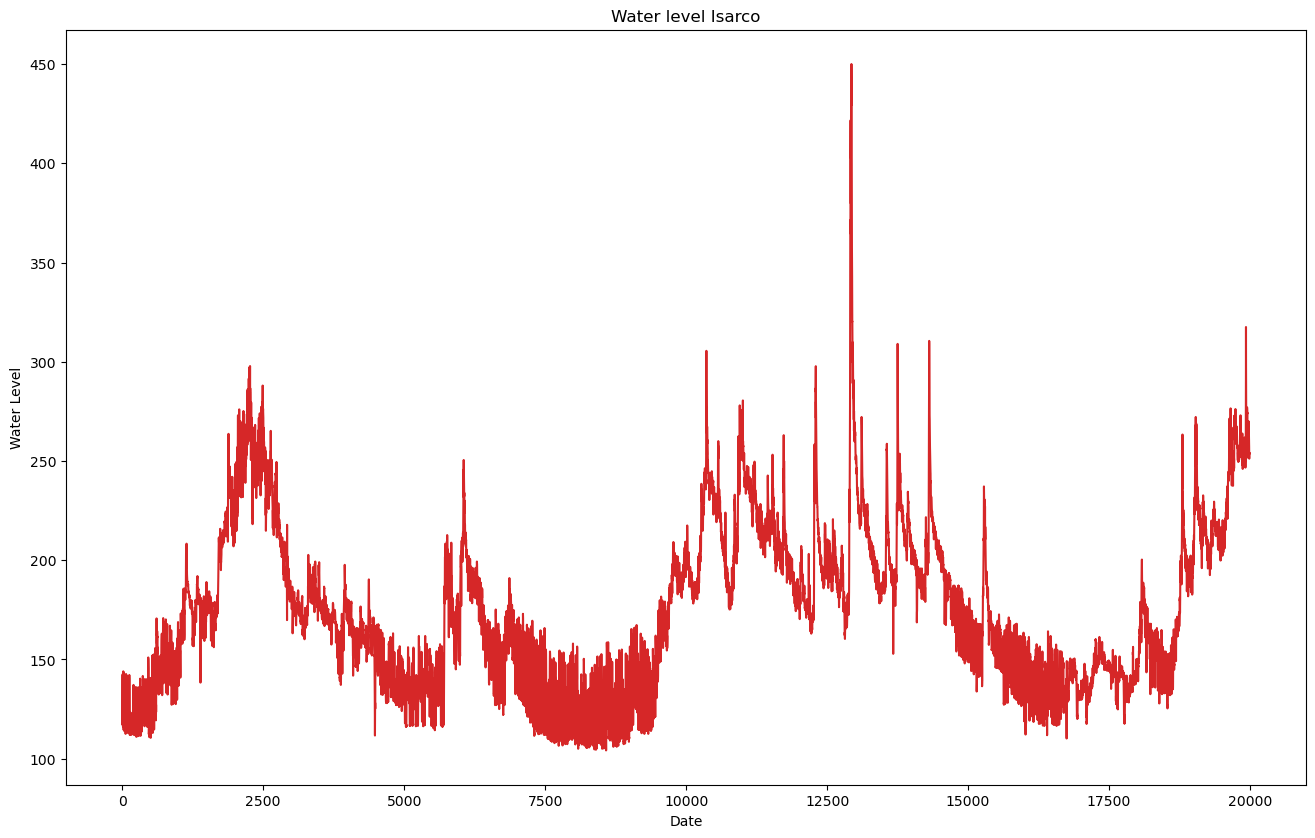

In [17]:
# Plot the daily temperature change 
plt.figure(figsize=(16,10), dpi=100)
plt.plot(df.index, df['W_mean'], color='tab:red')
# MODIFICARE I TICKS 
plt.gca().set(title="Water level Isarco", xlabel='Date', ylabel="Water Level")
plt.show()

<ipython-input-17-934fea2eae33>:4: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result_add = seasonal_decompose(df.W_mean, model='additive', extrapolate_trend='freq', freq=365)


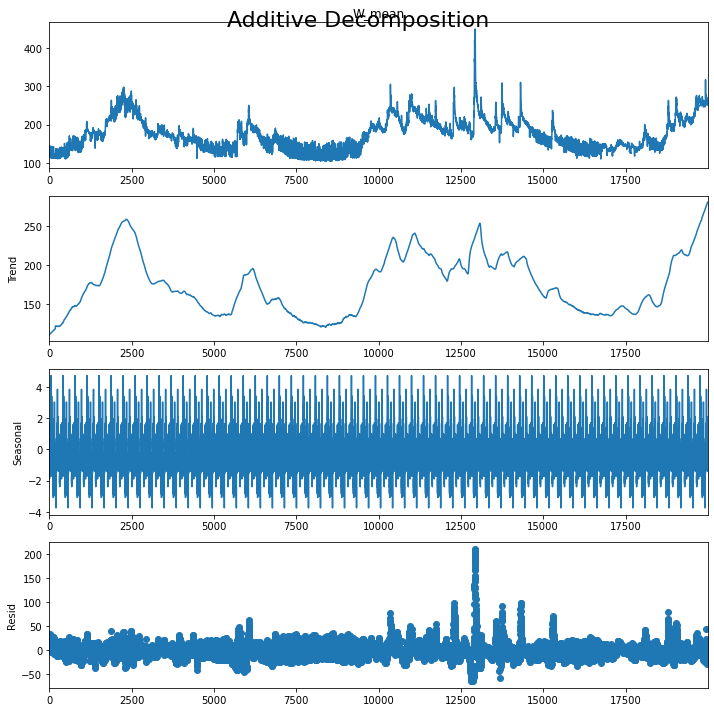

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Additive Decomposition
result_add = seasonal_decompose(df.W_mean, model='additive', extrapolate_trend='freq', freq=365)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decomposition', fontsize=22)
plt.show()

In [19]:
# Shift the current temperature to the next day. 
predicted_df = df["W_mean"].to_frame().shift(1).rename(columns = {"W_mean": "W_mean_pred" })
actual_df = df["W_mean"].to_frame().rename(columns = {"W_mean": "W_mean_actual" })

# Concatenate the actual and predicted temperature
one_step_df = pd.concat([actual_df,predicted_df],axis=1)

# Select from the second row, because there is no prediction for today due to shifting.
one_step_df = one_step_df[1:]
one_step_df.head(10)


,W_mean_actual,W_mean_pred
1,121.00,117.33
2,133.17,121.00
3,137.50,133.17
4,138.67,137.50
5,142.50,138.67
6,142.33,142.50
7,133.67,142.33
8,122.33,133.67
9,117.50,122.33
10,117.83,117.50


In [20]:
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt

# Calculate the RMSE
temp_pred_err = MSE(one_step_df.W_mean_actual, one_step_df.W_mean_pred, squared=False)
print("The RMSE is",temp_pred_err)

The RMSE is 4.234348966491368


__Weather Forecast using SARIMA model__

In [21]:


import itertools

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [22]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(one_step_df.W_mean_actual,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [23]:
# Import the statsmodels library for using SARIMAX model
import statsmodels.api as sm

# Fit the SARIMAX model using optimal parameters
mod = sm.tsa.statespace.SARIMAX(one_step_df.W_mean_actual,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

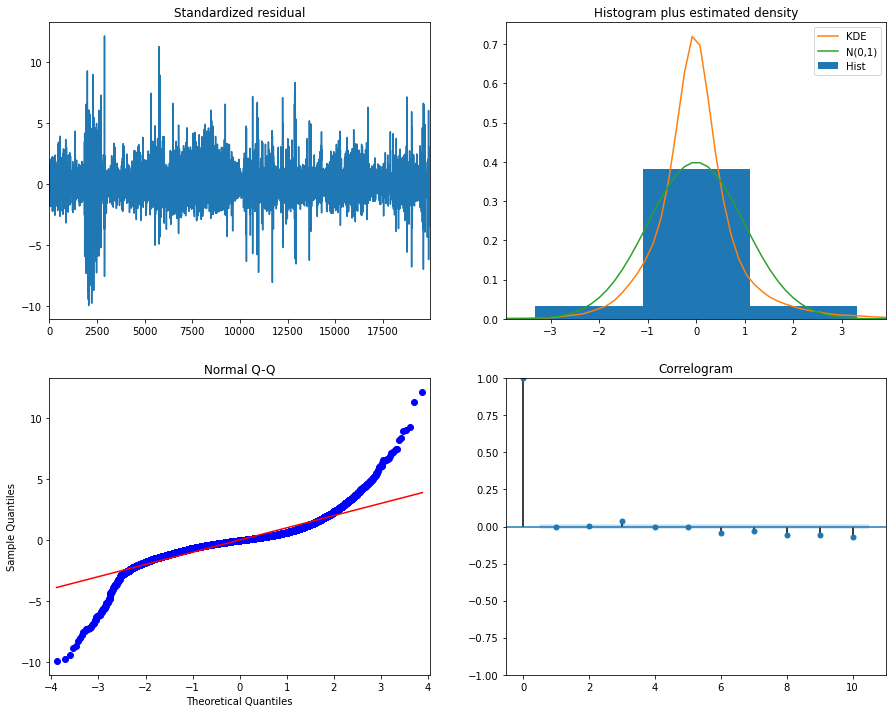

In [24]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [53]:
start_pred = len(df)

pred_1h = start_pred +1
pred_3h = start_pred + 3
pred_12h = start_pred +12
pred_1d = start_pred + 24
pred_3d = start_pred + 72
pred_1w = start_pred + 168
pred = results.get_prediction(start = pred_12h , dynamic=False)
pred_ci = pred.conf_int()
print(type(pred_ci)
     )

<class 'pandas.core.frame.DataFrame'>


['238.678993 - 269.111099', '233.859053 - 274.039259', '221.290619 - 289.00454', '210.703267 - 299.912525', '177.505864 - 335.741668', '120.790603 - 397.635254']


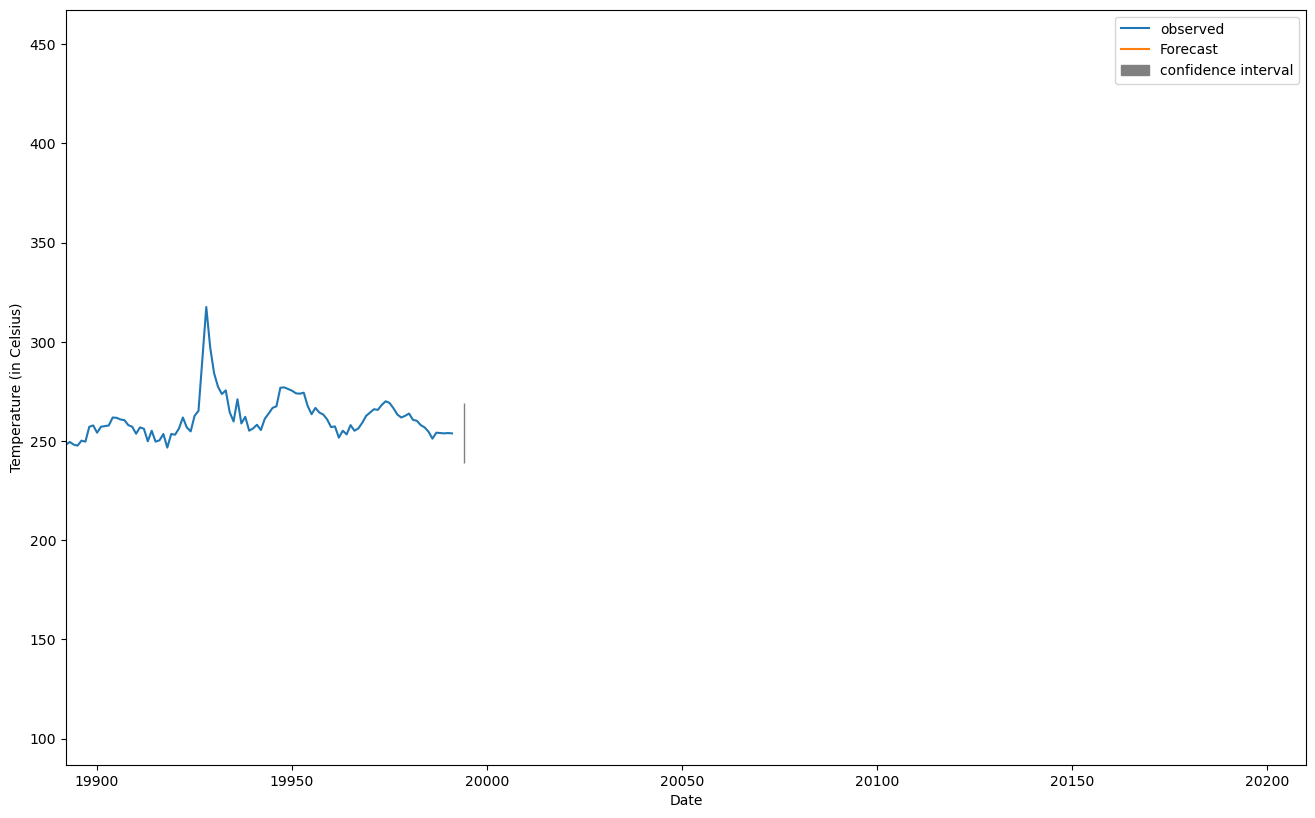

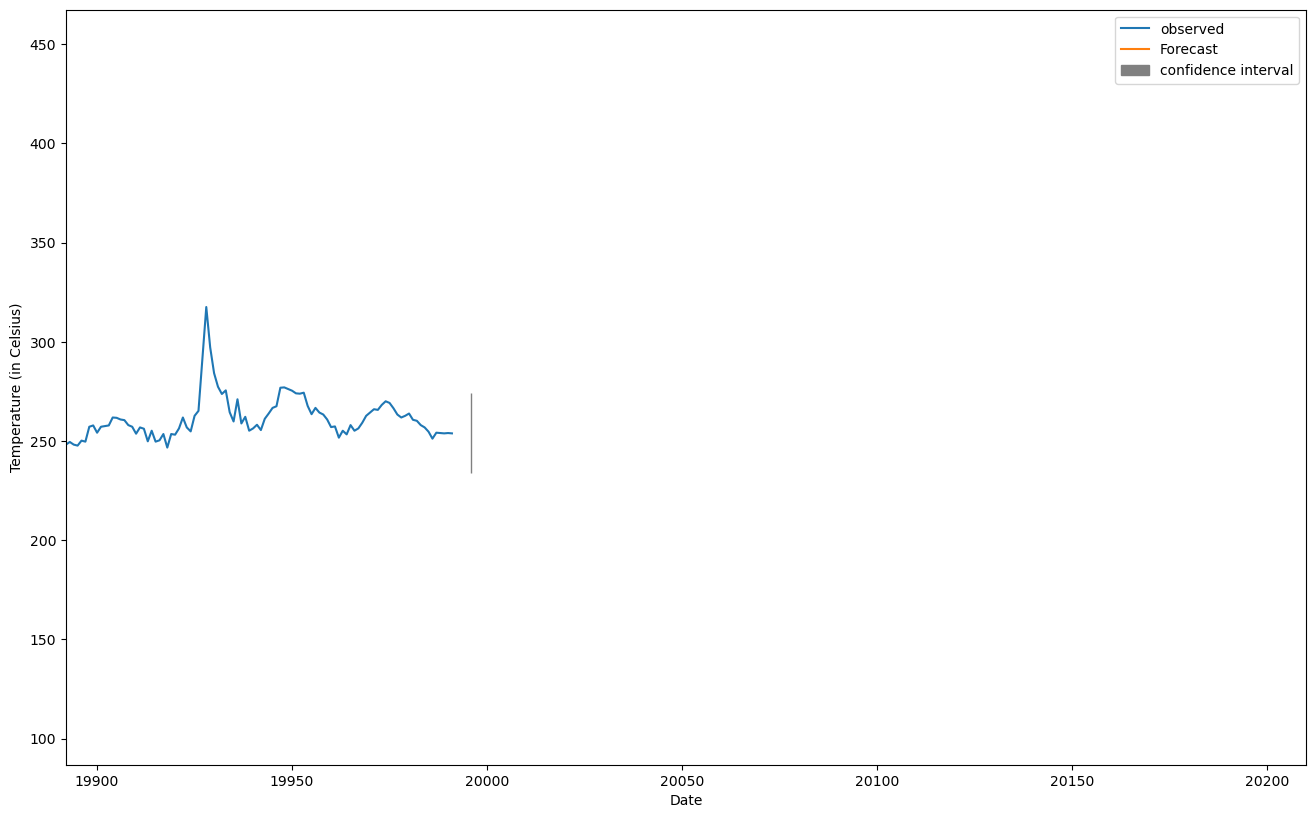

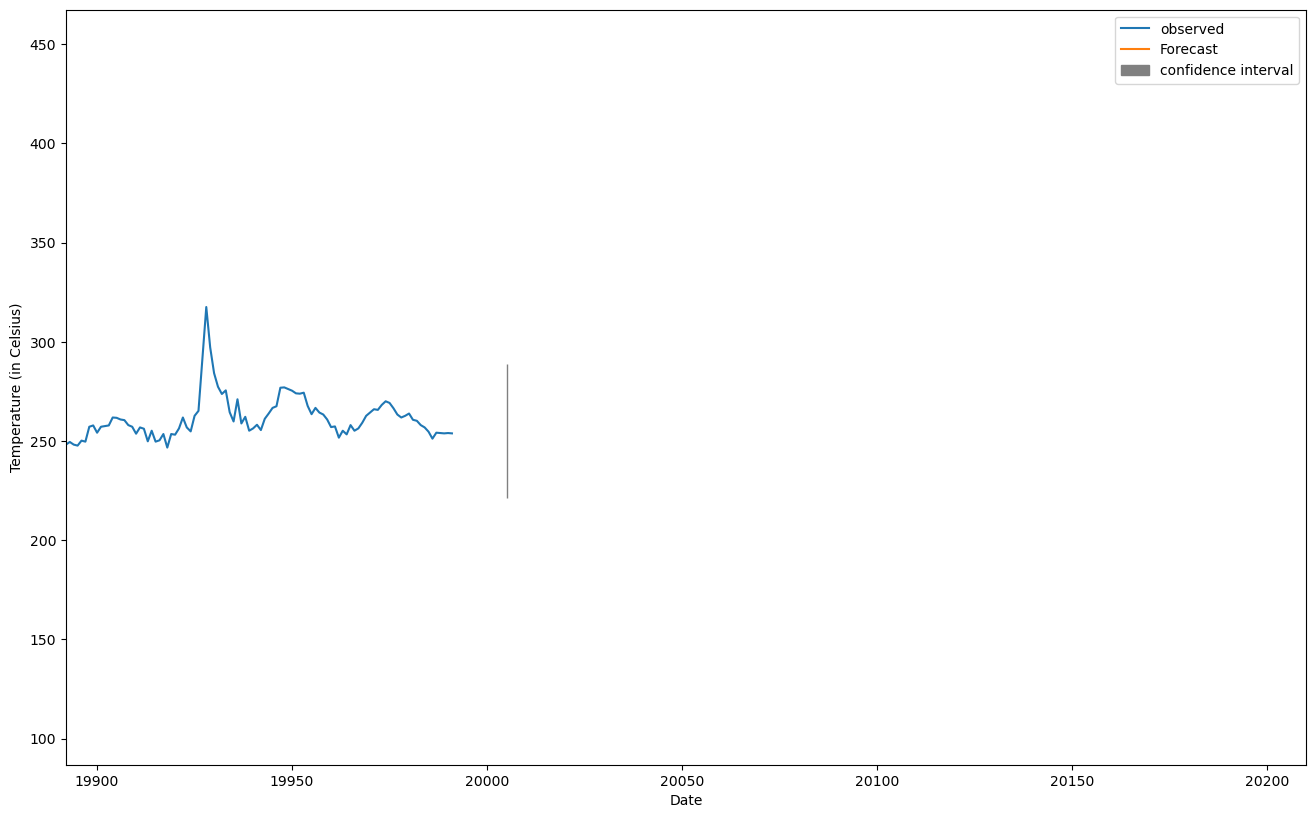

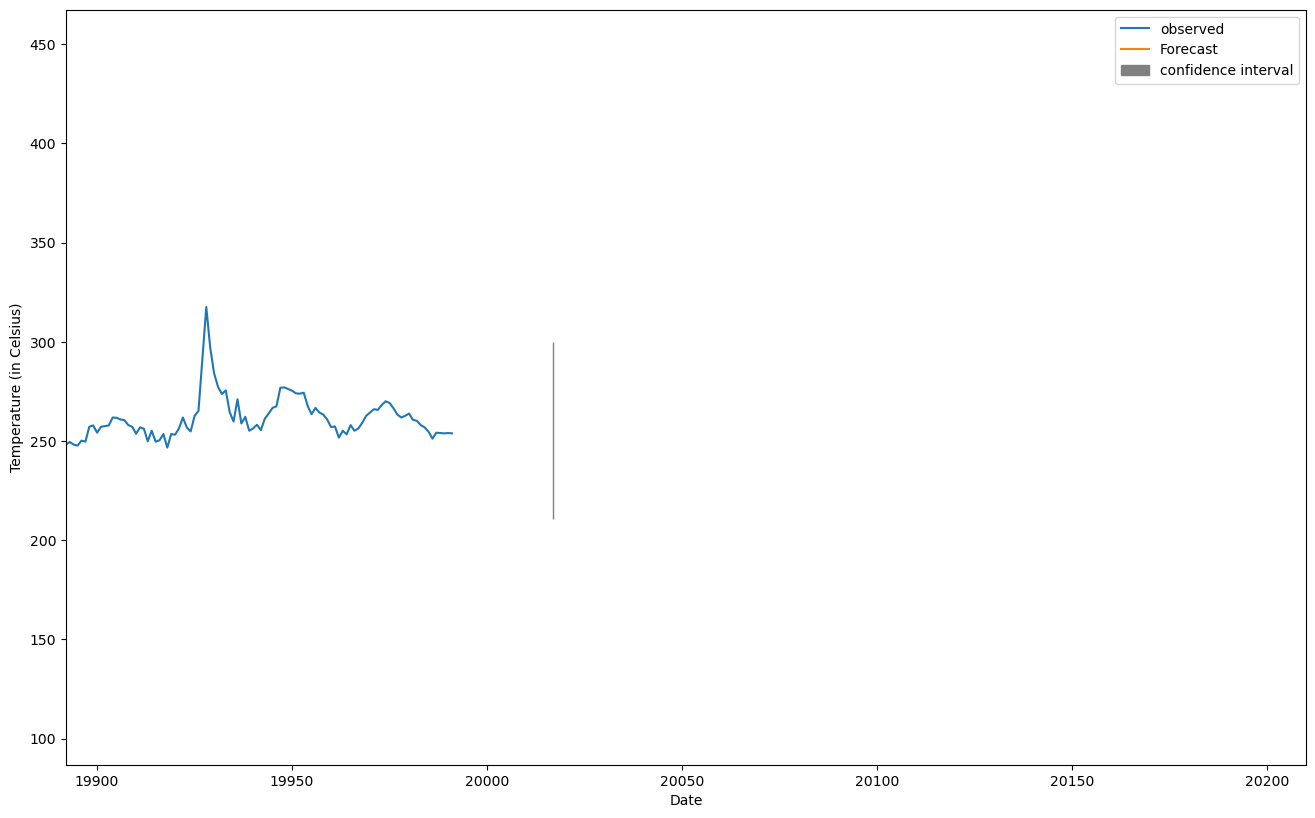

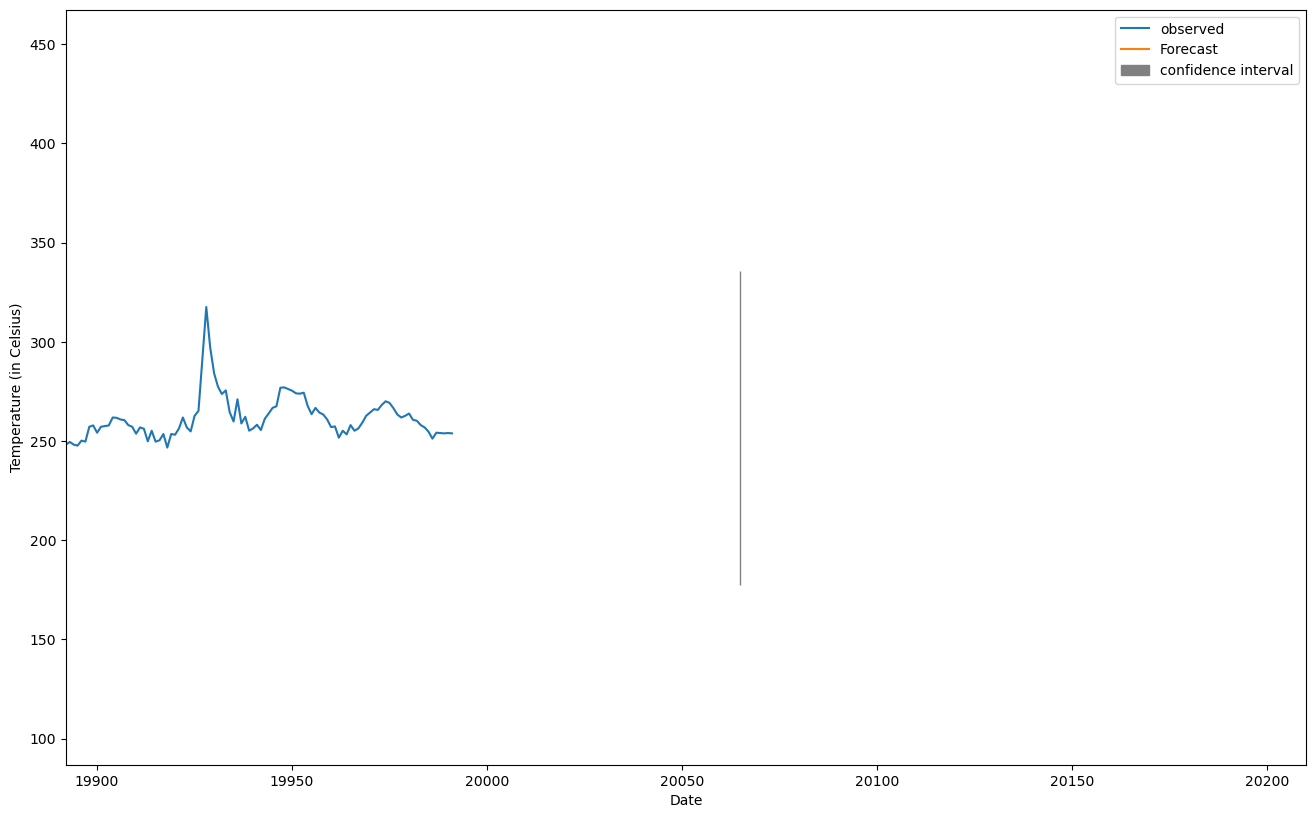

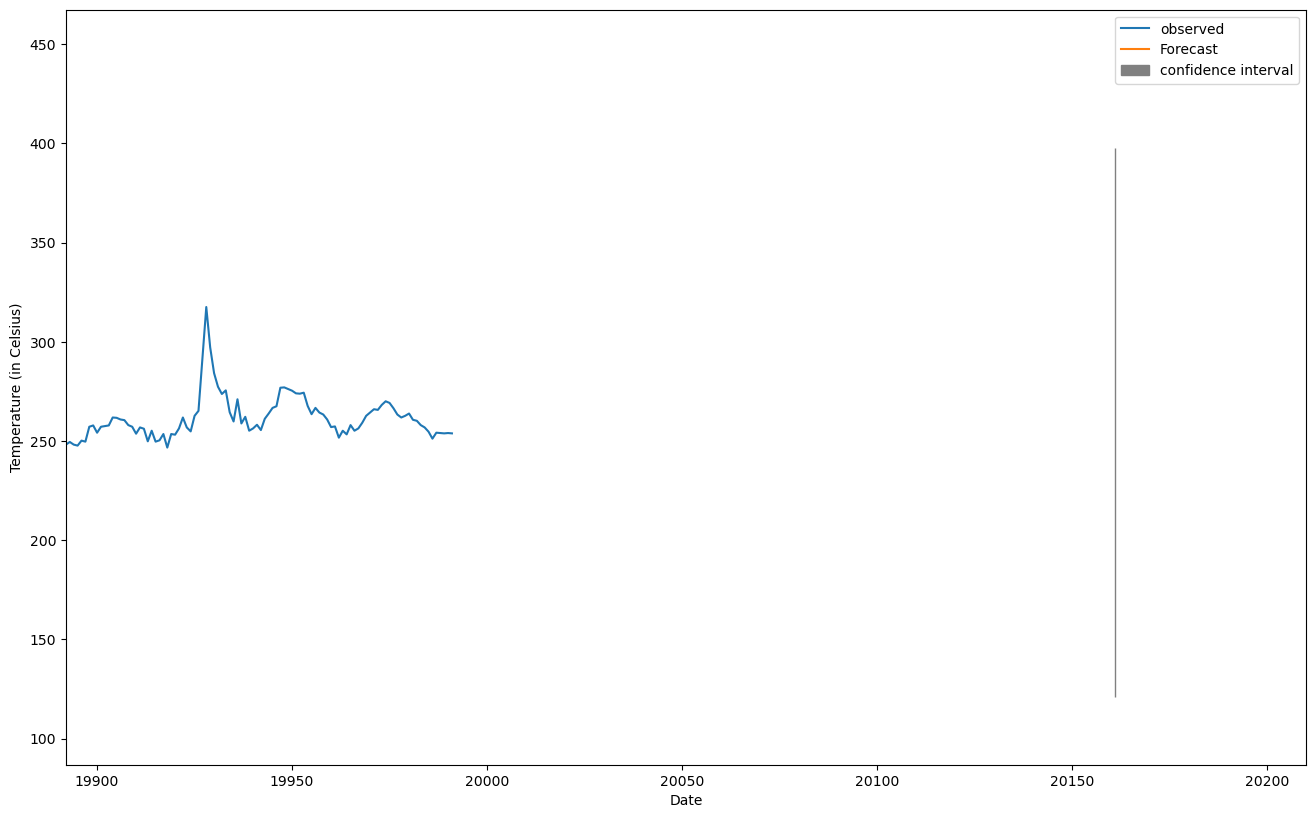

In [78]:
pred_list = [pred_1h,
pred_3h,
pred_12h,
pred_1d,
pred_3d,
pred_1w]
list_output = []
for pred_time in pred_list:
    pred = results.get_prediction(start = pred_time , dynamic=False)
    pred_ci = pred.conf_int()
    output_l = str(pred_ci['lower W_mean_actual']).split()
    output_u = str(pred_ci['upper W_mean_actual']).split()
    #output = str(pred_ci['lower W_mean_actual']) + str(pred_ci['upper W_mean_actual'])
    output = output_l[1] + ' - ' + output_u[1]
    list_output.append(output)
    plt.figure(figsize=(16,10), dpi=100)
    ax = one_step_df.W_mean_actual[:].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='Forecast')

    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='grey', alpha=1, label = 'confidence interval')

    ax.set_xlabel('Date')
    ax.set_ylabel('Temperature (in Celsius)')
    plt.legend()
    plt.xlim([start_pred -100,pred_1w + 50])
    #print(pred_ci.iloc[:, 0])
    #print(pred_ci.iloc[:, 1])
    #plt.show()
print(list_output)


In [62]:
y_forecasted = pred.predicted_mean
y_truth = one_step_df.W_mean_actual[16147:]
# Compute the mean square error
mse = MSE(y_truth, y_forecasted, squared=True)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

20161    259.212929
dtype: float64
16148    130.33
16149    133.17
16150    133.67
16151    146.00
16152    148.00
          ...  
19987    254.17
19988    254.00
19989    253.83
19990    254.00
19991    253.83
Name: W_mean_actual, Length: 3844, dtype: float64
(1,)
(3844,)


ValueError: Found input variables with inconsistent numbers of samples: [3844, 1]

In [84]:
pred_dynamic = results.get_prediction(start=16147, dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

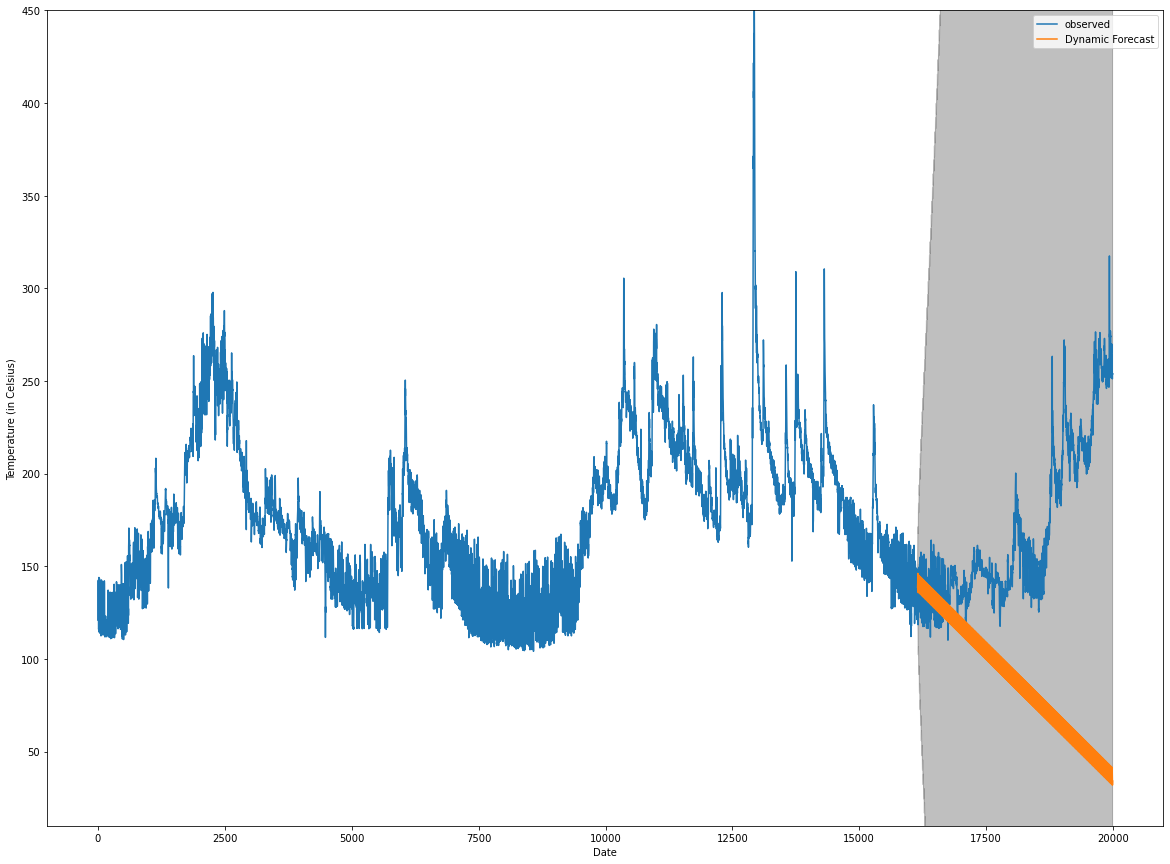

In [85]:
ax = one_step_df.W_mean_actual[:].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)


ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([10,450])
plt.legend()
plt.show()

In [86]:

# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = one_step_df.W_mean_actual[16147:]

# Compute the mean square error
mse = sqrt(MSE(y_truth, y_forecasted).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Root Mean Squared Error of our forecasts is 108.21
